#### Setup and Data Download

[Data Documentation Kaggle](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data)

[Data Documentation Instacart](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
import contextlib
from google.colab import files
import io

with contextlib.redirect_stdout(io.StringIO()):
    files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c instacart-market-basket-analysis

! unzip /content/instacart-market-basket-analysis.zip -d zipped_data

! unzip /content/zipped_data/aisles.csv.zip -d /content/data/
! unzip /content/zipped_data/departments.csv -d /content/data/
! unzip /content/zipped_data/order_products__prior.csv.zip -d /content/data/
! unzip /content/zipped_data/order_products__train.csv.zip -d /content/data/
! unzip /content/zipped_data/orders.csv.zip -d /content/data/
! unzip /content/zipped_data/products.csv.zip -d /content/data/ 

! rm -rf /content/instacart-market-basket-analysis.zip
! rm -rf /content/data/__MACOSX
! rm -rf /content/zipped_data

### EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
aisles = pd.read_csv('/content/data/aisles.csv')
departments = pd.read_csv('/content/data/departments.csv')
prior_orders = pd.read_csv('/content/data/order_products__prior.csv')
train_orders = pd.read_csv('/content/data/order_products__train.csv')
orders = pd.read_csv('/content/data/orders.csv')
products = pd.read_csv('/content/data/products.csv')

Let's look at each of the files individually

In [6]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [7]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


From the Data Documentation - 

These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items.

In [10]:
prior_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
train_orders.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [12]:
print(f"Total Number of Distinct users : {orders['user_id'].nunique()}")
print(f'Distinct Aisles : ', aisles.shape[0])
print(f'Distinct Departments : ', departments.shape[0])
print(f'Distinct Orders : ', orders.shape[0])
print(f'Distinct Products : ', products.shape[0])
print(f'Total number of prior orders : ', prior_orders.shape[0])
print(f'Total number of train orders : ', train_orders.shape[0])

Total Number of Distinct users : 206209
Distinct Aisles :  134
Distinct Departments :  21
Distinct Orders :  3421083
Distinct Products :  49688
Total number of prior orders :  32434489
Total number of train orders :  1384617


### Busiest day of the week

As per multiple Github discussions, Day of the Week 0 maps to Sunday, and 6 to Saturday. We'll use the info to get the busiest day of the week!

In [13]:
map_daynum_to_dayname = {
    0 : 'Sunday',
    1 : 'Monday',
    2 : 'Tuesday',
    3 : 'Wednesday',
    4 : 'Thursday',
    5 : 'Friday',
    6 : 'Saturday'
}

# Create a subset of Order ID and Order Day of the Week from the orders dataframe
orders_subset = orders.loc[:, ['order_id', 'order_dow']]
# Map Day number to Day name
orders_subset['order_dow_name'] = orders.loc[:, 'order_dow'].map(map_daynum_to_dayname)
orders_subset.head()

,order_id,order_dow,order_dow_name
0,2539329,2,Tuesday
1,2398795,3,Wednesday
2,473747,3,Wednesday
3,2254736,4,Thursday
4,431534,4,Thursday


This worked fine!

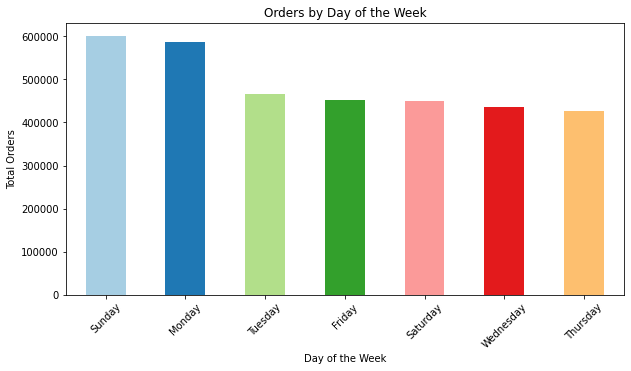

In [14]:
# Group by Day name, count Order IDs, and sort descending
orders_grouped = orders_subset.groupby(['order_dow_name'])['order_id'].count().sort_values(ascending=False)

# Plot the bar chart
orders_grouped.plot(kind='bar', title='Orders by Day of the Week', ylabel='Total Orders',
         xlabel='Day of the Week', figsize=(10, 5), rot = 45, color=plt.cm.Paired(np.arange(len(orders_grouped))));

Sundays and Mondays are busiest days of the week, while Thursday is the least busy

### Breakdown of Orders by Hour of the Day

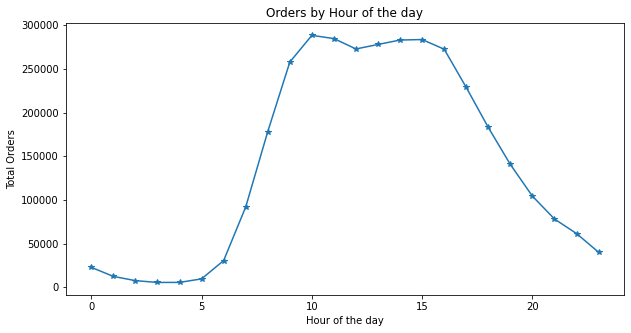

In [15]:
# Create a subset of Order ID and Order Day of the Week from the orders dataframe
orders_subset = orders.loc[:, ['order_id', 'order_hour_of_day']]

# Group by Day name, count Order IDs and sort descending
orders_grouped = orders_subset.groupby(['order_hour_of_day'])['order_id'].count()

# Create Line chart
orders_grouped.plot(style='-*', title='Orders by Hour of the day', ylabel='Total Orders',
         xlabel='Hour of the day', figsize=(10, 5));

### Max Products by Department

There are 21 Departments and total 49688 products. Let's see which Departments has maximum products

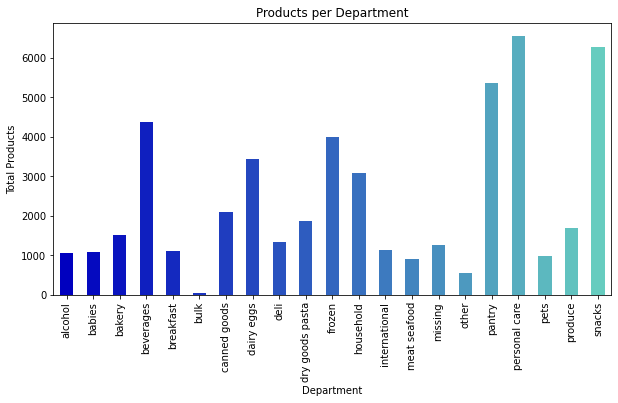

In [16]:
# Merge Products and Departments, and add Department Name to products df
products_df_with_dept_name = products.merge(departments, on='department_id',how='left')

# Group by Department and count products
prod_dept_grouped = products_df_with_dept_name.groupby(['department'])['product_id'].count()

# Define Color list - (r,g,b) values
my_colors = [(x/50.0, x/25.0, 0.75) for x in range(len(prod_dept_grouped))]

# Plot the bar chart
prod_dept_grouped.plot(kind='bar', stacked = True,title='Products per Department', ylabel='Total Products',
         xlabel='Department', figsize=(10, 5), rot = 90, color = my_colors);

### Top 10 Popular Items

Which 10 products are ordered the most and how much?

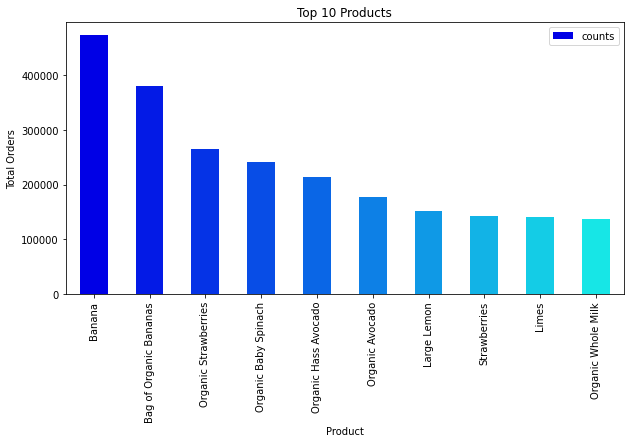

In [59]:
# Count products (or the ids) in the prior_order df and
# then use products df to get the product name
# Get prod count by using value_count, then rename axis and index and 
# select top 10 rows (value_counts is sorted descending by default)
top10prods_df = prior_orders['product_id']\
                            .value_counts()\
                            .rename_axis('product_id')\
                            .reset_index(name='counts')\
                            .iloc[0:10,:]

# Merge with products df
top10prodsname_df = top10prods_df.merge(products[['product_id', 'product_name']], how='left',on='product_id')

# Define Color list - (r,g,b) values
my_colors = [(x/100.0, x/10.0, 0.9) for x in range(len(top10prodsname_df))]

# Plot bar chart
top10prodsname_df.plot(kind='bar',x='product_name',y='counts', stacked = True,title='Top 10 Products', ylabel='Total Orders',
         xlabel='Product', figsize=(10, 5), rot = 90, color = my_colors);

General items, fruit, milk etc make up the entire top 10

Above, we only took into the consideration the Prior orders. Let's look at how the results impact if we add train_orders as well

> Note that there are no common order_id in prior_orders and train_orders, so combining them will not create duplication!

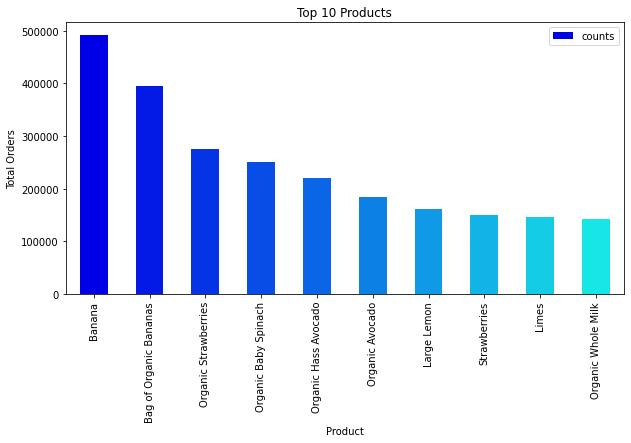

In [68]:
# Concat products from prior and train orders
all_orders_prods = pd.concat([prior_orders, train_orders])

# Repeat the process from above
top10prods_df = all_orders_prods['product_id']\
                            .value_counts()\
                            .rename_axis('product_id')\
                            .reset_index(name='counts')\
                            .iloc[0:10,:]

# Merge with products df
top10prodsname_df = top10prods_df.merge(products[['product_id', 'product_name']], how='left',on='product_id')

# Define Color list - (r,g,b) values
my_colors = [(x/100.0, x/10.0, 0.9) for x in range(len(top10prodsname_df))]

# Plot bar chart
top10prodsname_df.plot(kind='bar',x='product_name',y='counts', stacked = True,title='Top 10 Products', ylabel='Total Orders',
         xlabel='Product', figsize=(10, 5), rot = 90, color = my_colors);

No change! Makes sense given that the train_order has less than even 5% records as prior_orders

### Shelf Space by Department

How many products per department - Top 10

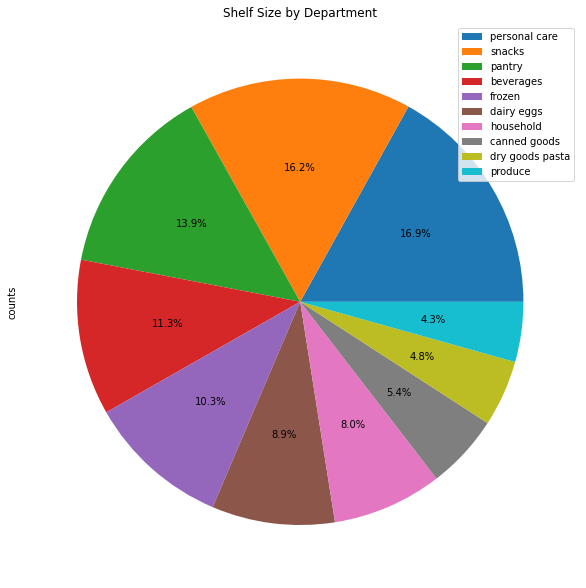

In [103]:
# Merge products and departments
prod_per_dept = products[['product_id', 'department_id']].merge(departments, on='department_id',how='left')

# Group by Department and count products
prod_per_dept_grouped = prod_per_dept.groupby('department')['product_id'].count()\
                                     .rename_axis('department')\
                                     .reset_index(name='counts')\
                                     .sort_values('counts', ascending=False)\
                                     .iloc[0:10,:]

# Set index
prod_per_dept_grouped.set_index('department', inplace=True)

# Plot pie chart
prod_per_dept_grouped.plot.pie(title = 'Shelf Size by Department', y='counts', autopct='%1.1f%%',figsize=(10, 20), labeldistance=None);

#### Setup Spark

For additional details, refer to [Github Notebook](https://github.com/suvigyajain0101/Utils/blob/main/SetupSparkOnColab.ipynb)

In [110]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [127]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz

In [ ]:
!tar -xvf /content/spark-3.3.0-bin-hadoop3.tgz

In [129]:
!pip install -q findspark

In [132]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

In [133]:
import findspark
findspark.init()

### Data Preparation - Arrange Shopping Baskets

Convert the data into the format as expected by the ML Model

In [135]:
from pyspark.sql.functions import collect_set, col, count
from pyspark import SparkContext
from pyspark.sql import SQLContext 


sc = SparkContext("local", "App Name")
sql = SQLContext(sc)

/content/spark-3.3.0-bin-hadoop3/python/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [146]:
# Register Products and train_orders as Spark DFs
products_sdf = sql.createDataFrame(products)
train_orders_sdf = sql.createDataFrame(train_orders)

# Create temp views for SQL Query
products_sdf.createOrReplaceTempView('products')
train_orders_sdf.createOrReplaceTempView('train_orders')

# Merge Products and train_orders and get product_name
rawData = sql.sql("select p.product_name, o.order_id from products p inner join train_orders o where o.product_id = p.product_id")
# Group data from above on order_id and create set of all the products 
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')

baskets.head()

Row(order_id=1, items=['Bulgarian Yogurt', 'Cucumber Kirby', 'Lightly Smoked Sardines in Olive Oil', 'Organic 4% Milk Fat Whole Milk Cottage Cheese', 'Organic Whole String Cheese', 'Organic Celery Hearts', 'Organic Hass Avocado', 'Bag of Organic Bananas'])